In [1]:
from spotifyAPI import *

#Script to obtain data 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv("music_mood_dataset.csv")

In [3]:
col_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [4]:
#Encode the moods
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)

dummy_y = np_utils.to_categorical(encoded_y)

X_train, X_test, Y_train, Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
0,calm,0
999,energetic,1
1998,happy,2
2998,sad,3


In [5]:
mean_scores = df.groupby('mood')[col_features].mean()
print(mean_scores)


           danceability    energy   loudness  speechiness  acousticness  \
mood                                                                      
calm           0.383277  0.082014 -25.855441     0.045122      0.935699   
energetic      0.707396  0.775316  -6.154298     0.096190      0.083743   
happy          0.654962  0.590505  -8.845468     0.077739      0.346080   
sad            0.492164  0.330498 -13.621506     0.054865      0.639966   

           instrumentalness  liveness   valence       tempo  
mood                                                         
calm               0.814920  0.112144  0.214684   99.555285  
energetic          0.202184  0.181270  0.560438  124.311706  
happy              0.331879  0.169074  0.577236  117.812091  
sad                0.212516  0.140674  0.298971  115.187020  


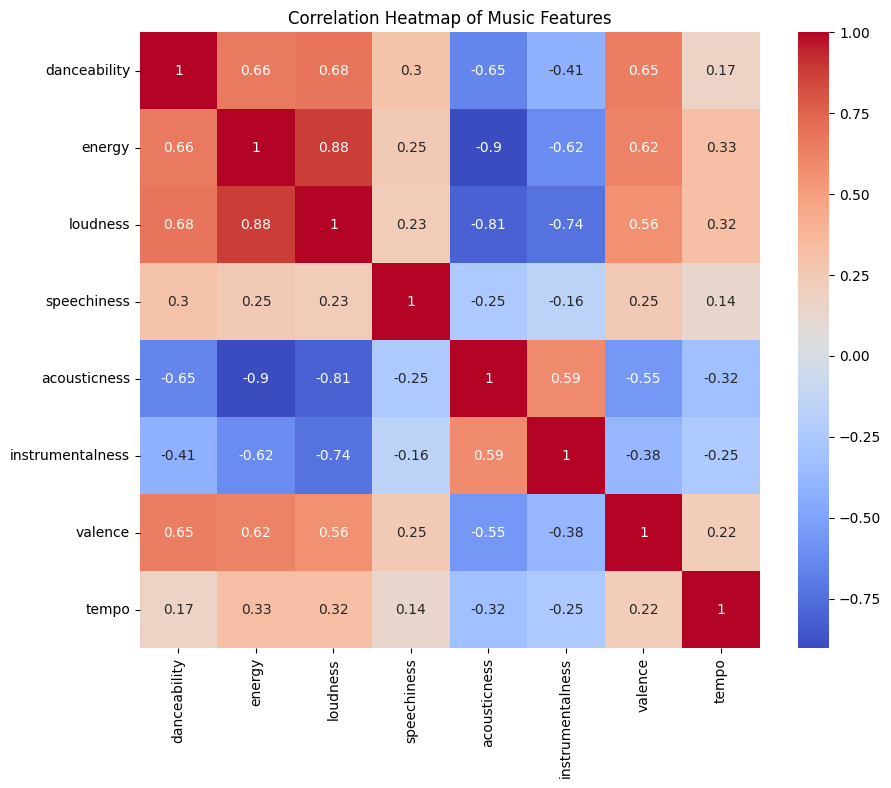

In [6]:
col_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']

# Subset the DataFrame to include only the col_features
subset_df = df[col_features]

# Compute the correlation matrix for the subset
corr_matrix = subset_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Music Features')
plt.show()


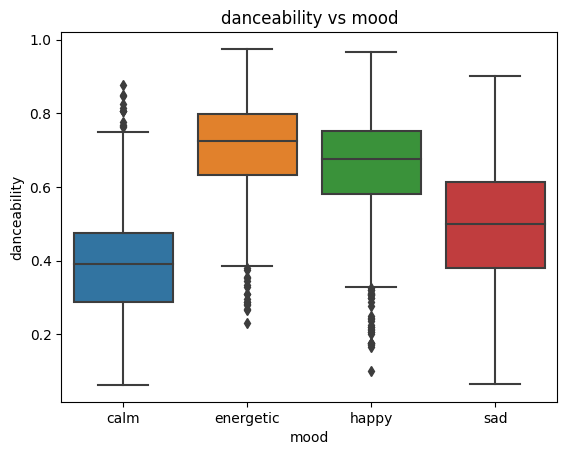

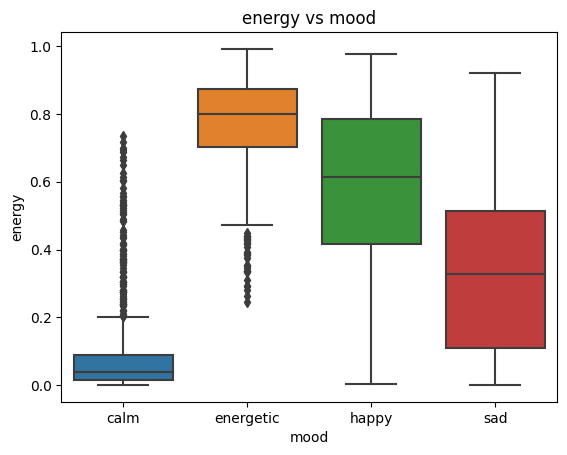

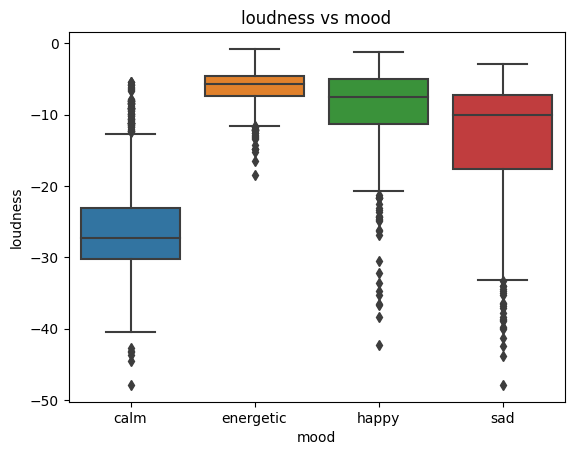

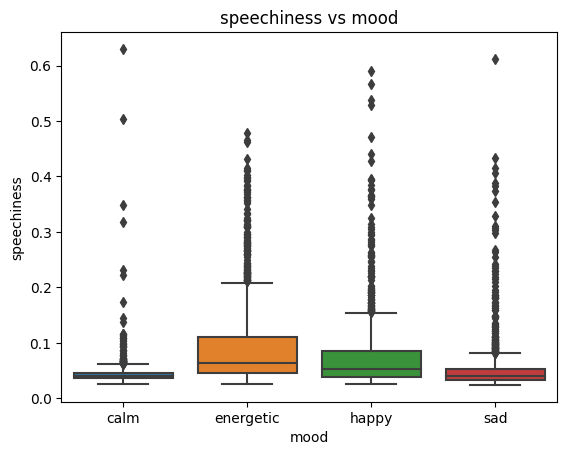

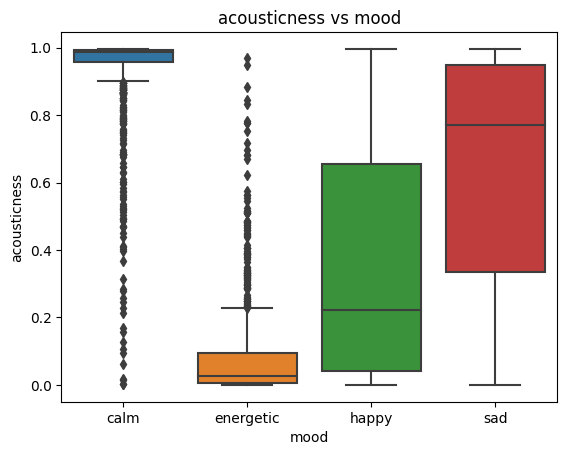

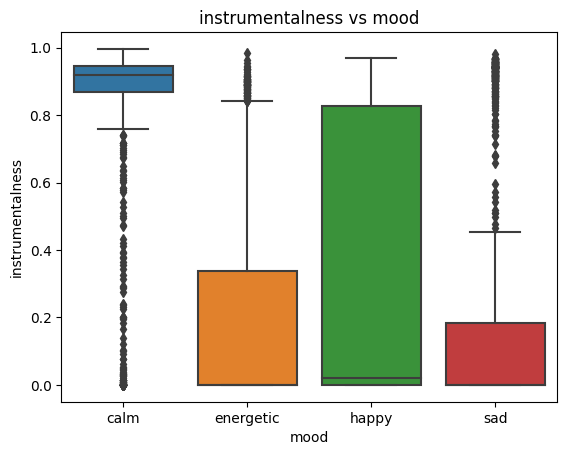

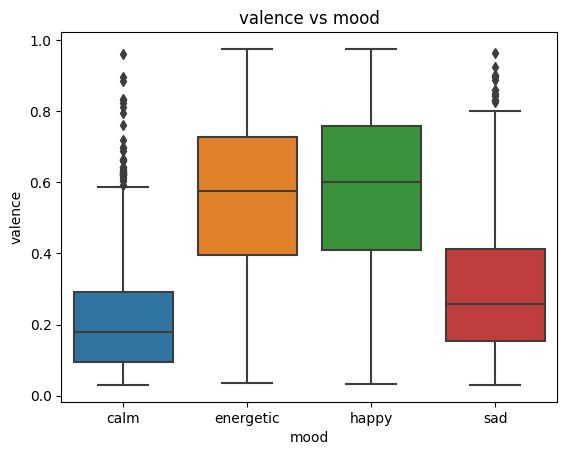

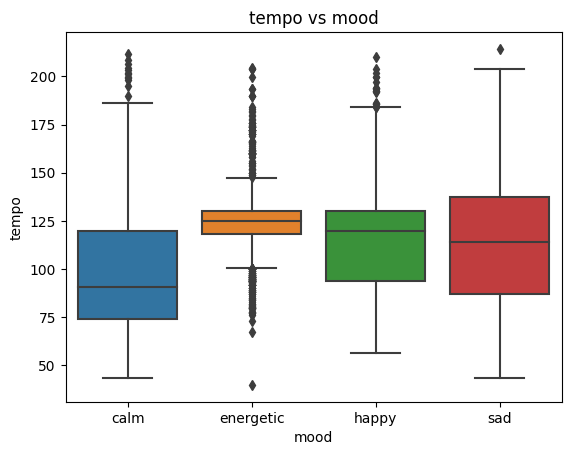

In [7]:
# Generate box plots for each feature
for col in col_features:
    sns.boxplot(x='mood', y=col, data=df)
    plt.title(col + ' vs mood')
    plt.show()


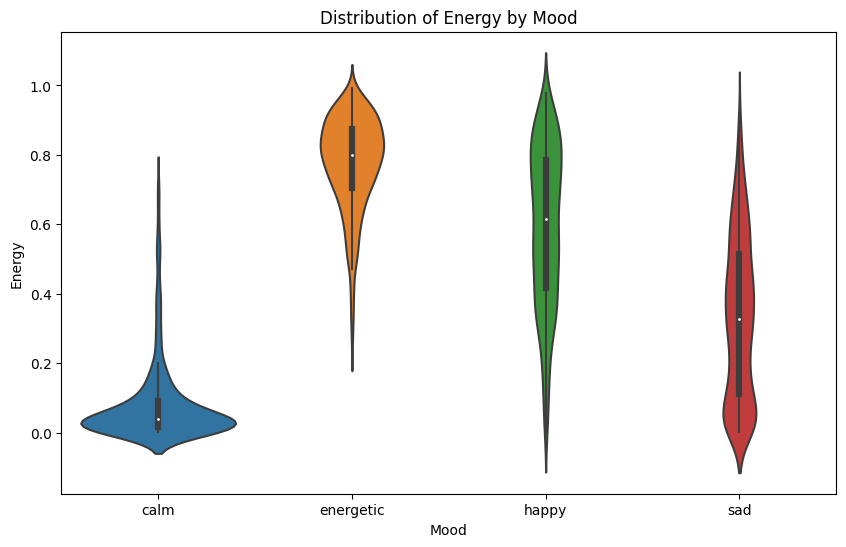

In [8]:
# Create a violin plot of 'valence' grouped by 'mood'
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='mood', y='energy')

# Set the plot labels and title
plt.title('Distribution of Energy by Mood')
plt.xlabel('Mood')
plt.ylabel('Energy')

# Show the plot
plt.show()


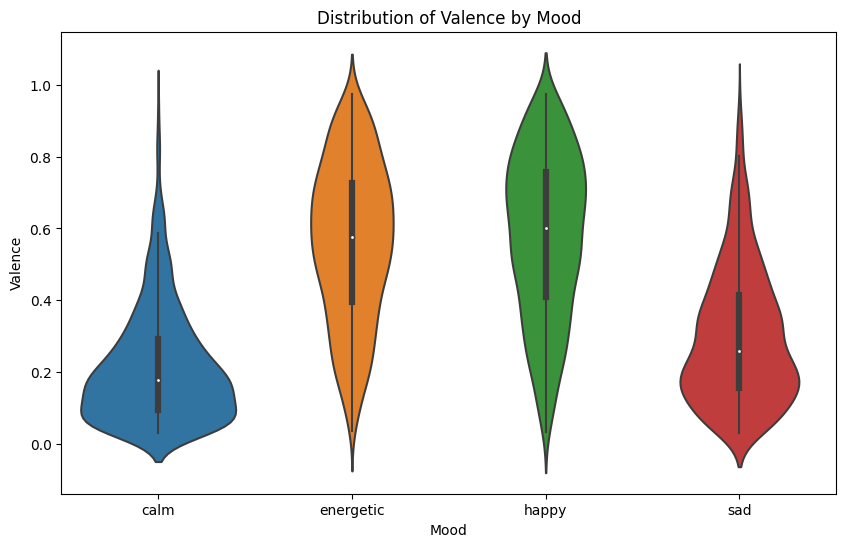

In [9]:
# Create a violin plot of 'valence' grouped by 'mood'
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='mood', y='valence')

# Set the plot labels and title
plt.title('Distribution of Valence by Mood')
plt.xlabel('Mood')
plt.ylabel('Valence')

# Show the plot
plt.show()


In [10]:
def test_model():
    # Define the model
    model = Sequential()
    model.add(Dense(9, input_dim=9, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=test_model, epochs=100, batch_size=64, verbose=0)

C:\Users\ahmed\AppData\Local\Temp\ipykernel_12560\779773453.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=test_model, epochs=100, batch_size=64, verbose=0)


In [12]:
# Evaluate the model using K-Fold cross validation
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Baseline: 70.28% (2.45%)


In [13]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


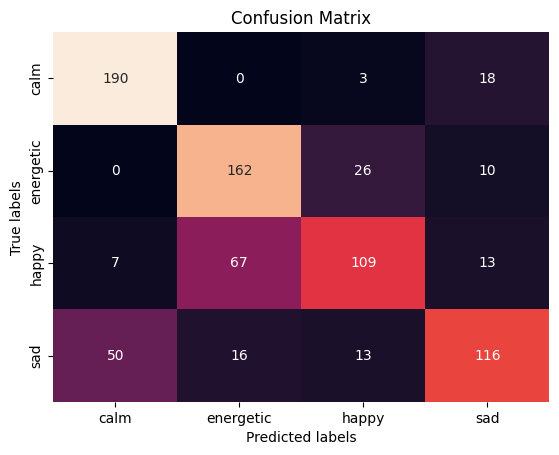

Accuracy Score: 0.72125


In [14]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True, ax=ax, cbar=False, fmt='g')

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score:", accuracy_score(Y_test,y_preds))

In [15]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler', MinMaxScaler()), ('keras', KerasClassifier(build_fn=test_model, epochs=100,
                                                                                  batch_size=64, verbose=0))])
    #Fit the Pipeline
    pip.fit(X2, encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][7:-1]).reshape(1, -1)

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode'] == int(results)])
    name_song = preds[0][1]
    artist = preds[0][2]

    return print("CLASSIFICATION RESULT: {0} by {1} is a {2} song".format(name_song, artist, mood[0].upper()))

In [20]:
predict_mood('2P4ZWACQ1CH3K9fvfeJu6L')

C:\Users\ahmed\AppData\Local\Temp\ipykernel_12560\1600582818.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler', MinMaxScaler()), ('keras', KerasClassifier(build_fn=test_model, epochs=100,


CLASSIFICATION RESULT: Wehyat Kalby by Abdel Halim Hafez is a HAPPY song


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
